### Installation Instructions

Good to start with the Anaconda Python distribution since it has most of the necessary packages
* conda install numpy scipy mkl nose sphinx pydot-ng
* conda install theano pygpu
* conda install pydot graphviz
* pip install keras
* pip install PyUserInput
* pip install parameterized
* pip install pyscreenshot
* pip install opencv-python

In [2]:
import os
os.environ['KERAS_BACKEND']='theano'
import theano
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [3]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

### The Chrome T-Rex

The Chrome T-Rex is a fun and simple game that is present within the Chrome browser. It appears everytime when an internet connection is not detected. So when there is no internet connection, users can play a fun game while they wait for the page to load. It is more popular in countries with patchy internet connections or when users are travelling

You can try this game yourself in your Chrome browser by switching off the Wi-Fi or Ethernet connections. It would appear something like the animation below

In [3]:
from IPython.display import HTML
HTML('<img src="./screenshot.gif">')

### Problem Statement

Our objective is to create a program that can play the Chrome T-Rex game autonomously without any human input. There are several ways of achieving this - 
- Build a simple rule based engine that sees the image on the screen and if the incoming obstacle is at a certain distance to the T-Rex, then we make it jump. This is an explicit rule based computer program where you as the human are telling the computer what to do.
- However, since we are in an Introduction to Neural Networks class, we would like to teach the computer to learn to play the game itself. We do not want to give it any explicit instructions. So the rest of this notebook will focus on creating a neural network solution to the Chrome T-Rex game.

Let's have some fun!


#### Solution Approach

Our approach is to create a program that can auto-play the Chrome T-Rex game. We will create a supervised neural network to play this game. This neural network will be able to look at the images coming in from the screen and take a decision on whether the T-Rex must jump or not. 

Therefore, the objective of our neural network should be to recognize an obstacle and provide the JUMP output. In order to do this we will follow a three step approach - 

1. Generate training data by playing the game
2. Train a neural network that uses the training data to understand obstacles and jump
3. Validate the performance of the neural network by showing some sample images

#### Step 1:

The first step of any supervised learning algorithm is to have a set of labelled training data. These data points capture the scene of the game in our case and also have a label associated with them which indicates what action was taken.

We can easily capture this training data by taking screenshots of the game as we are playing it. However to simplify things for us, we already have a set of captured images that we can work with. Let's take a look at some of them now.

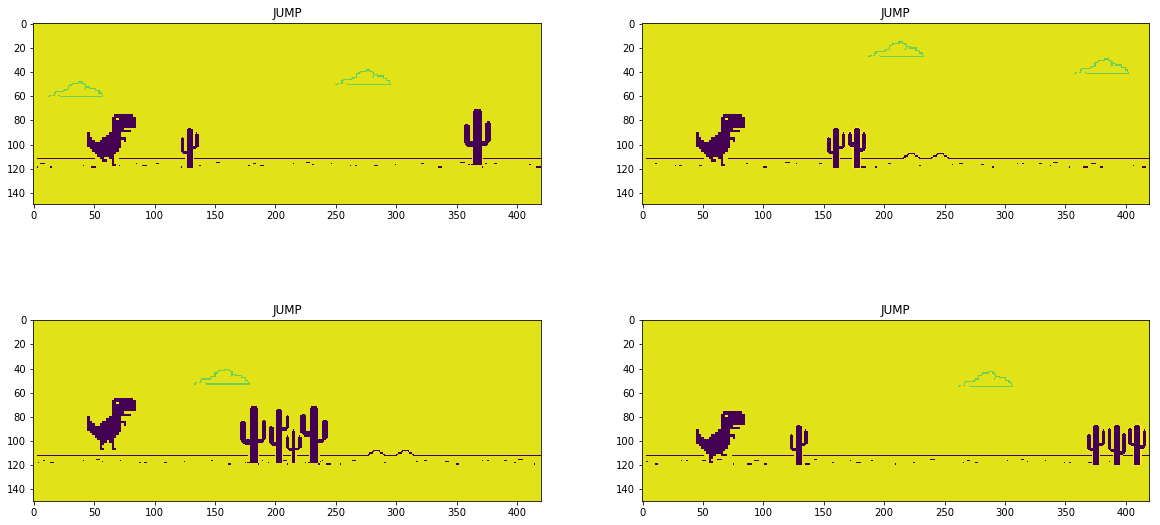

In [4]:
fig = plt.figure(figsize=(20,20))

a=fig.add_subplot(1,2,1)
img1 = Image.open('./imgfolder-new/jump.png')
imgplot = plt.imshow(img1)
a.set_title('JUMP')

a=fig.add_subplot(1,2,2)
img12 = Image.open('./imgfolder-new/jump12.png')
imgplot = plt.imshow(img12)
a.set_title('JUMP')

a=fig.add_subplot(2,2,1)
img21 = Image.open('./imgfolder-new/jump21.png')
imgplot = plt.imshow(img21)
a.set_title('JUMP')

a=fig.add_subplot(2,2,2)
img43 = Image.open('./imgfolder-new/jump43.png')
imgplot = plt.imshow(img43)
a.set_title('JUMP')

* These are all examples of images where the correct action for the T-Rex is to JUMP

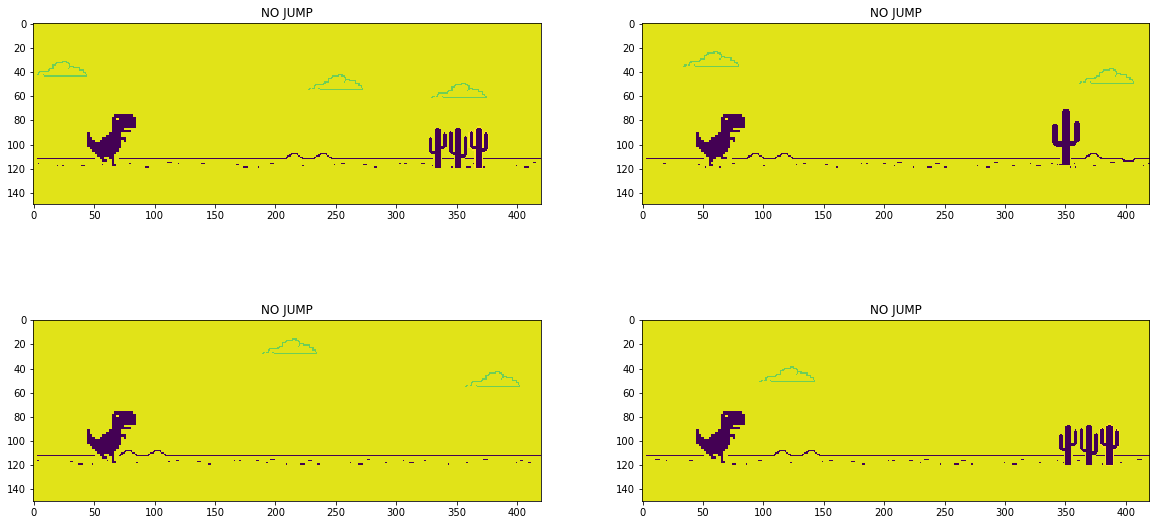

In [5]:
fig = plt.figure(figsize=(20,20))

a=fig.add_subplot(1,2,1)
img1 = Image.open('./imgfolder-new/nojump6.png')
imgplot = plt.imshow(img1)
a.set_title('NO JUMP')

a=fig.add_subplot(1,2,2)
img12 = Image.open('./imgfolder-new/nojump22.png')
imgplot = plt.imshow(img12)
a.set_title('NO JUMP')

a=fig.add_subplot(2,2,1)
img21 = Image.open('./imgfolder-new/nojump41.png')
imgplot = plt.imshow(img21)
a.set_title('NO JUMP')

a=fig.add_subplot(2,2,2)
img43 = Image.open('./imgfolder-new/nojump56.png')
imgplot = plt.imshow(img43)
a.set_title('NO JUMP')

* These are examples of images where the T-Rex will not jump because the obstacle is further away or there is no obstacle
* This is just a selection of such images that we have in the training data, let's look at how many images we have totally

In [33]:
def modlistdir(path):
    listing = os.listdir(path)
    jumpretlist = []
    nojumpretlist = []
    for name in listing:
        #This check is to ignore any hidden files/folders
        if name.startswith('.'):
            continue
        elif name.startswith('jump'):
            jumpretlist.append(name)
        elif name.startswith('nojump'):
            nojumpretlist.append(name)
    return jumpretlist, nojumpretlist

In [34]:
jumpImg, nojumpImg = modlistdir('./imgfolder-new')
print "Number of JUMP Images - " + str(len(jumpImg))
print "Number of NO JUMP Images - " + str(len(nojumpImg))

Number of JUMP Images - 245
Number of NO JUMP Images - 265


#### Splitting the Data

* We have a similar number of training examples for JUMP and NOJUMP labels and overall we have approximately 500 images
* We will now split these images into a Training dataset and Test dataset
* The training dataset will be used to training our neural network and the test dataset will be used to check if our model works well

In [35]:
# input image dimensions
img_rows, img_cols = 150, 420

# number of channels
# For grayscale use 1 value and for color images use 3 (R,G,B channels)
img_channels = 1

imgPath = './imgfolder-new'
imlist = jumpImg + nojumpImg
immatrix = np.array([np.array((Image.open(imgPath+ '/' + images).resize((img_rows,img_cols))).convert('L')).flatten()
                         for images in imlist], dtype = 'f')

image1 = np.array(Image.open(imgPath +'/' + imlist[0]))
m,n = image1.shape[0:2]

print "Size of each image - "
print m,n
print "Size of image matrix - "
print immatrix.shape

Size of each image - 
150 420
Size of image matrix - 
(510, 63000)


Identifying the label with the correct action - this is where we are labelling our data

* A label of 0 means that the action for this image is to jump - which is the case for the first 245 images that we have in the folder

* A lable of 1 means that the action for this image is to not do anything (since there is no obstacle) - this is the case for the rest of 265 images in our dataset

In [36]:
total_images = len(imlist)
label=np.ones((total_images,),dtype = int)
label[0:245]=0    # jump label
label[245:]=1     # nojump label

* The following code is used to shuffle the images and then split them into Training and Test datasets in 80:20 ratio

* Therefore, we will train the model on 80% of the images and then check if the model works well on 20% of the cases

In [37]:
# Shuffling the dataset so we get a mix of JUMP/NOJUMP images in training and test data
data,Label = shuffle(immatrix,label, random_state=23)
train_data = [data,Label]
(X, y) = (train_data[0],train_data[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)

* We ensure that the distribution of JUMP and NOJUMP images across training and test datasets is reasonably consistent

In [38]:
print "::::::::::Training Data:::::::::"
print "Number of total images: " + str(len(X_train))
print "Number of JUMP images: " + str(y_train.sum())
print "Testing Data"
print "Number of total images: " + str(len(X_test))
print "Number of JUMP images: " + str(y_test.sum())

::::::::::Training Data:::::::::
Number of total images: 408
Number of JUMP images: 210
Testing Data
Number of total images: 102
Number of JUMP images: 55


In [39]:
# Number of target classes that we want to predict
nb_classes = 2

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

### Step2

We have finished creating the Training and Test datasets and it is now time to train the model.

For the purpose of this game, we are going to train a Convolutional Neural Network (CNN). This is similar to the basic Neural Network that we looked at earlier but is primarily used in the case of <b>image processing</b>. We will not go into the details of a CNN at this point since it will be covered in one of the Student projects.

In [40]:
# Total number of convolutional filters to use
nb_filters = 32

# Size of convolution kernel
nb_conv = 3

# Max pooling
nb_pool = 2

# input image dimensions
img_rows, img_cols = 150, 420

# number of channels
# For grayscale use 1 value and for color images use 3 (R,G,B channels)
img_channels = 1

# Initialize the model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(nb_filters, (nb_conv, nb_conv),
                        padding='valid',
                        input_shape=(img_channels, img_rows, img_cols)))

# Set the activation function for this later to relu (Rectified Linear Unit)
convout1 = Activation('relu')

# Add the first convolutional layer to the neural network
model.add(convout1)

# Add the second convolutional layer to the neural network
model.add(Conv2D(nb_filters, (nb_conv, nb_conv)))
convout2 = Activation('relu')
model.add(convout2)

# Add a max pooling layer with Dropout to the neural network
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

# Add some additional layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

# Add another dropout layer
model.add(Dropout(0.5))
model.add(Dense(nb_classes))

# Set the activation function of final layer
model.add(Activation('softmax'))

# Set the loss function to be optimized and choose the optimizer
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

* Now that we have defined the model, we can look at the various layers of this particular Neural Network
* It's not important to focus on the layers at this points. These architectures are normally arrived based on several research papers and more understanding of the domain
* For now, we can assume this is the best architecture for this problem and proceed with our problem

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 148, 418)      320       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 148, 418)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 146, 416)      9248      
_________________________________________________________________
activation_12 (Activation)   (None, 32, 146, 416)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 73, 208)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 73, 208)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 485888)            0         
__________

<b>Model Training</b>

* It is now time to train our model. We setup several parameters to determine how we train this model. These are - 
1. <i>batch_size</i> - this tells the model how many images to consider for each gradient descent calculation
2. <i>nb_epoch</i> - this tells the model how many passes it should take on the entire dataset. 1 epoch is one complete pass through the data
3. <i>validation_split</i> - this tells the model to validate the results after each epoch on a 20% split of the training data itself, so that we can determine whether the model training is actually progressing

In [42]:
# Batch_size to train
batch_size = 32

# Number of epochs to train (change it accordingly)
nb_epoch = 5

hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)

Train on 326 samples, validate on 82 samples
Epoch 1/5
326/326 [==============================] - 89s 272ms/step - loss: 5.8223 - acc: 0.5092 - val_loss: 4.8688 - val_acc: 0.5244
Epoch 2/5
326/326 [==============================] - 85s 261ms

#### Progress of Model Training

* The model is nothing but an optimization function that tries to find the values of the weights and biases that are good at mapping from Input to Output
* It does this in a stage-wise manner by first picking 32 images (batch_size) and then adjusting the weights after averaging the error across this set of images
* This process is repeated for every set of 32 images till all the images in the training dataset (326) have been processed - this is the end of one epoch
* At this point, it uses the model parameters to predict JUMP/NPJUMP on the validation dataset (82) and prints the loss function and the accuracy for the validation dataset at the end of each epoch
* This way we can know if the model is becoming better by training through multiple epochs
* The same concepts can be visualized through the graphs below - 
1. The first one tracks training loss and the validation loss across different epochs
2. The second one track training accuracy and validation accuracy across different epochs
* Ideally, if the model is getting better, both of these should move close to each other through the epochs. If they start to diverge, then it means that the model has started overfitting

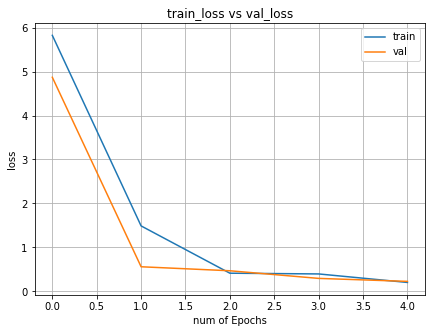

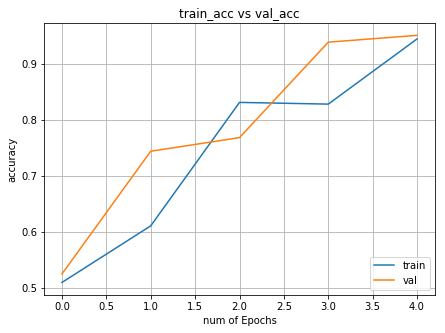

In [43]:
def visualizeHis(hist):
    # visualizing losses and accuracy

    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['acc']
    val_acc=hist.history['val_acc']
    xc=range(nb_epoch)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    #plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)

    plt.show()
    
visualizeHis(hist)

We then save the model parameters that have been learnt to a file that can be used later on our Testing dataset

In [44]:
fname = "./modelParams.hdf5"
model.save_weights(fname,overwrite=True)

### Step3

* We have now trained our model and saved the parameters. We can use this to now see what the model would predict on the images in the Training dataset.
* Note that these are images that the model has not seen till now, so this is an example of the model playing the game in real-time. It would read these images from the screen and based on that predict whether to JUMP or NOTJUMP.

In [57]:
print X_test.shape
print Y_test[1]
print y_test[1]

(102, 1, 150, 420)
[ 1.  0.]
0


In [53]:
# Define the function that provide model implementation
layer = model.layers[11]
get_output = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])

In [58]:
prob_array = get_output([X_test, 0])[0]

In [66]:
model_decision = []
for p in prob_array:
    if p[0] > 0.5 and p[0] > p[1]:
        model_decision.append(0)
    elif p[1] > 0.5 and p[1] > p[0]:
        model_decision.append(1)

In [81]:
correct_count = 0
total_count = 0
for pred, real in zip(model_decision, y_test):
    if pred == int(real):
        correct_count = correct_count + 1
    total_count = total_count + 1
print "Error on Test Dataset: " + str(correct_count*1.0/total_count)

Error on Test Dataset: 0.980392156863


### Getting the Intuition

* We have now found that our model works on the Test dataset as well but what does it really mean?
* Let's try and get some intution about our results but using some images from a completely different dataset.
* This also contains the same kind of images but somebody else has created this Training dataset
* Another way to actually see if our model works is to make it play the game itself - we can do a short demo of this

In [98]:
# First we just define some helper functions that we can use directly with the image path

def predictImage(imgpath):
    # We need to perform the same pre-processing steps that we did on other images
    image = np.array((Image.open(imgpath).resize((img_rows,img_cols))).convert('L')).flatten()
    image = image.astype('float32')
    image = image / 255
    rimage = image.reshape(1, img_channels, img_rows, img_cols)
    # Call the model to get the probability range
    prob_array = get_output([rimage, 0])[0]
    return returnPrediction(prob_array)

# Return the prediction based on the probability value
def returnPrediction(prob_array):
    model_decision = []
    for p in prob_array:
        if p[0] > 0.5 and p[0] > p[1]:
            model_decision.append('JUMP')
        elif p[1] > 0.5 and p[1] > p[0]:
            model_decision.append('NOJUMP')
    return model_decision

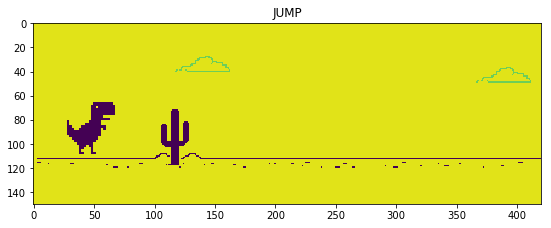

In [84]:
# Let's load one of the images in this dataset
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
img1 = Image.open('./imgfolder-test/jump1.png')
imgplot = plt.imshow(img1)
a.set_title('JUMP')

* We can clearly see that this is a JUMP image, and it has also been labelled as such
* But we need to check now what our model would say if it had seen the same image

In [99]:
print predictImage('./imgfolder-test/jump1.png')

['JUMP']


* So the model seems to be working correctly
* Let's try for another image now, but for the NO Jump type

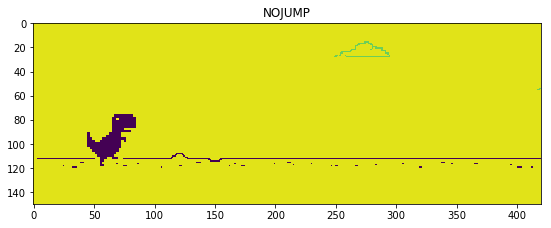

In [119]:
# Let's load one of the images in this dataset
fig = plt.figure(figsize=(20,20))
a=fig.add_subplot(1,2,1)
img1 = Image.open('./imgfolder-new/nojump3.png')
imgplot = plt.imshow(img1)
a.set_title('NOJUMP')

In [122]:
print predictImage('./imgfolder-new/nojump2.png')

['NOJUMP']
